# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

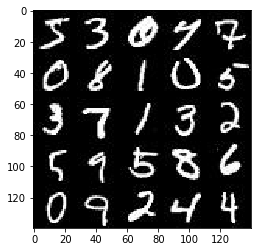

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

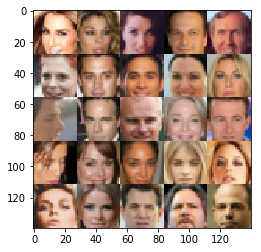

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.1
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # real input images placeholder
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    # noise placeholder
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, None, name='learn_rate')

    return inputs_real, inputs_z, learning_rate

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [35]:
def discriminator(images, reuse=False, alpha=0.2):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 32x32x3 (maybe?)
        #print('disc.images.shape:', images.shape)
        image_layer1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * image_layer1, image_layer1)
        #print('disc.image_layer1.shape:', relu1.shape)
        # 16x16x32

        image_layer2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(image_layer2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        #print('disc.image_layer2.shape:', relu2.shape)
        # 8x8x128

        image_layer3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(image_layer3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        #print('disc.image_layer3.shape:', relu3.shape)
        # 4x4x256

        # Flatten it
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        #print('disc.logits.shape:', logits.shape)
        #print('disc.out.shape:', out.shape)

    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [34]:
def generator(z, out_channel_dim, is_train=True, alpha=0.2):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    reuse = not is_train
    with tf.variable_scope('generator', reuse=reuse):
        #print('generator.z.shape:', z.shape)

        # First fully connected layer
        x1 = tf.layers.dense(z, 7*7*512)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        #print('gen.x1.shape:', x1.shape)

        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        #print('gen.x2.shape:', x2.shape)

        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=1, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        #print('gen.x3.shape:', x3.shape)

        # Output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=2, padding='same')
        #logits = tf.image.resize_images(logits, (28, 28))
        #print('gen.logits.shape:', logits.shape)
        # 28x28xout_channel_dim

        out = tf.tanh(logits)

        return out

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [36]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input (i.e., noise)
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(z=input_z, out_channel_dim=out_channel_dim)
    d_model_real, d_logits_real = discriminator(images=input_real, reuse=False)
    d_model_fake, d_logits_fake = discriminator(images=g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss    


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [38]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training optimizer, generator training optimizer)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):  
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [39]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [40]:

class GAN:
    def __init__(self, data_shape, z_dim, learning_rate, beta1=0.5):

        height = data_shape[1]
        width = data_shape[2]
        channels = data_shape[3]
        print('height: {}, width: {}, channels: {}, z_dim: {}'.format(height, width, channels, z_dim))
        self.input_real, self.input_z, self.learning_rate = \
            model_inputs(width, height, channels, z_dim)

        self.d_loss, self.g_loss = model_loss(self.input_real, self.input_z, channels)

        self.d_opt, self.g_opt = model_opt(self.d_loss, self.g_loss, self.learning_rate, beta1)


def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    print('data shape:', data_shape)
    net = GAN(data_shape, z_dim, learning_rate)
    
    saver = tf.train.Saver()

    samples, losses = [], []
    steps = 0
    print_every = 25
    show_every = 100

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                batch_images = batch_images * 2

                steps += 1

                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(net.d_opt, feed_dict={
                        net.input_real: batch_images, net.input_z: batch_z, net.learning_rate: learning_rate})
                _ = sess.run(net.g_opt, feed_dict={
                        net.input_real: batch_images, net.input_z: batch_z, net.learning_rate: learning_rate})

                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = net.d_loss.eval({
                            net.input_z: batch_z, net.input_real: batch_images, net.learning_rate: learning_rate})
                    train_loss_g = net.g_loss.eval({
                            net.input_z: batch_z, net.input_real: batch_images, net.learning_rate: learning_rate})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))

                if steps % show_every == 0:
                    show_generator_output(sess, 10, net.input_z, data_shape[3], data_image_mode)

        saver.save(sess, './checkpoints/generator.ckpt')

    #with open('samples.pkl', 'wb') as f:
    #    pkl.dump(samples, f)
    
    return losses, samples


### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

mkdir: cannot create directory ‘checkpoints’: File exists
data shape: (60000, 28, 28, 1)
height: 28, width: 28, channels: 1, z_dim: 100
generator.z.shape: (?, 100)
gen.x1.shape: (?, 4, 4, 512)
gen.x2.shape: (?, 8, 8, 256)
gen.x3.shape: (?, 16, 16, 128)
gen.logits.shape: (?, 28, 28, 1)
disc.images.shape: (?, 28, 28, 1)
disc.image_layer1.shape: (?, 14, 14, 64)
disc.image_layer2.shape: (?, 7, 7, 128)
disc.image_layer3.shape: (?, 4, 4, 256)
disc.logits.shape: (?, 1)
disc.images.shape: (?, 28, 28, 1)
disc.image_layer1.shape: (?, 14, 14, 64)
disc.image_layer2.shape: (?, 7, 7, 128)
disc.image_layer3.shape: (?, 4, 4, 256)
disc.logits.shape: (?, 1)
Epoch 1/2... Discriminator Loss: 0.3953... Generator Loss: 2.9809
Epoch 1/2... Discriminator Loss: 2.3139... Generator Loss: 0.9728
Epoch 1/2... Discriminator Loss: 0.6372... Generator Loss: 1.5321
Epoch 1/2... Discriminator Loss: 0.7290... Generator Loss: 1.0158
generator.z.shape: (?, 100)
gen.x1.shape: (?, 4, 4, 512)
gen.x2.shape: (?, 8, 8, 256)
ge

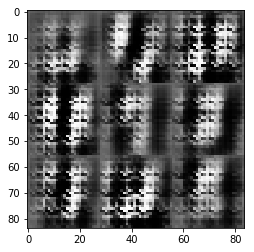

Epoch 1/2... Discriminator Loss: 1.0462... Generator Loss: 4.3096
Epoch 1/2... Discriminator Loss: 0.5284... Generator Loss: 2.6896
Epoch 1/2... Discriminator Loss: 0.5713... Generator Loss: 2.4373
Epoch 1/2... Discriminator Loss: 0.3898... Generator Loss: 1.8314
generator.z.shape: (?, 100)
gen.x1.shape: (?, 4, 4, 512)
gen.x2.shape: (?, 8, 8, 256)
gen.x3.shape: (?, 16, 16, 128)
gen.logits.shape: (?, 28, 28, 1)


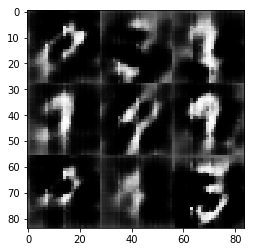

Epoch 1/2... Discriminator Loss: 0.9913... Generator Loss: 1.4820
Epoch 1/2... Discriminator Loss: 0.5365... Generator Loss: 1.4952
Epoch 1/2... Discriminator Loss: 1.0379... Generator Loss: 0.8425
Epoch 1/2... Discriminator Loss: 1.0831... Generator Loss: 1.0821
generator.z.shape: (?, 100)
gen.x1.shape: (?, 4, 4, 512)
gen.x2.shape: (?, 8, 8, 256)
gen.x3.shape: (?, 16, 16, 128)
gen.logits.shape: (?, 28, 28, 1)


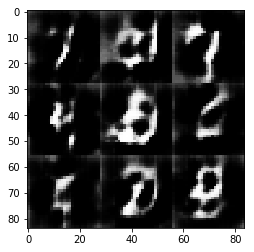

Epoch 1/2... Discriminator Loss: 1.4507... Generator Loss: 0.4491
Epoch 1/2... Discriminator Loss: 1.7278... Generator Loss: 0.3824
Epoch 1/2... Discriminator Loss: 1.6767... Generator Loss: 0.3356
Epoch 1/2... Discriminator Loss: 1.0764... Generator Loss: 0.6955
generator.z.shape: (?, 100)
gen.x1.shape: (?, 4, 4, 512)
gen.x2.shape: (?, 8, 8, 256)
gen.x3.shape: (?, 16, 16, 128)
gen.logits.shape: (?, 28, 28, 1)


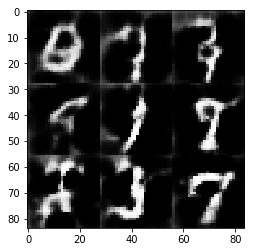

Epoch 1/2... Discriminator Loss: 1.8303... Generator Loss: 0.3051
Epoch 1/2... Discriminator Loss: 0.8113... Generator Loss: 1.0284
Epoch 2/2... Discriminator Loss: 0.9039... Generator Loss: 0.9488
Epoch 2/2... Discriminator Loss: 1.2970... Generator Loss: 0.8633
generator.z.shape: (?, 100)
gen.x1.shape: (?, 4, 4, 512)
gen.x2.shape: (?, 8, 8, 256)
gen.x3.shape: (?, 16, 16, 128)
gen.logits.shape: (?, 28, 28, 1)


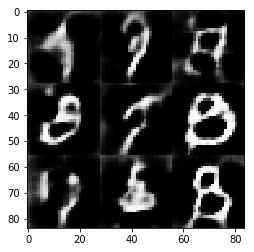

Epoch 2/2... Discriminator Loss: 0.7627... Generator Loss: 1.9209
Epoch 2/2... Discriminator Loss: 1.2090... Generator Loss: 0.5573
Epoch 2/2... Discriminator Loss: 1.6164... Generator Loss: 0.3094
Epoch 2/2... Discriminator Loss: 1.6698... Generator Loss: 0.3295
generator.z.shape: (?, 100)
gen.x1.shape: (?, 4, 4, 512)
gen.x2.shape: (?, 8, 8, 256)
gen.x3.shape: (?, 16, 16, 128)
gen.logits.shape: (?, 28, 28, 1)


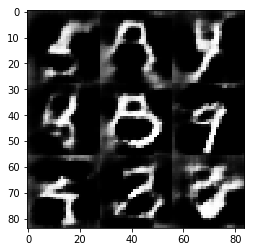

Epoch 2/2... Discriminator Loss: 0.9085... Generator Loss: 1.3172
Epoch 2/2... Discriminator Loss: 0.8944... Generator Loss: 0.8483
Epoch 2/2... Discriminator Loss: 0.9245... Generator Loss: 1.1797
Epoch 2/2... Discriminator Loss: 0.9288... Generator Loss: 1.1515
generator.z.shape: (?, 100)
gen.x1.shape: (?, 4, 4, 512)
gen.x2.shape: (?, 8, 8, 256)
gen.x3.shape: (?, 16, 16, 128)
gen.logits.shape: (?, 28, 28, 1)


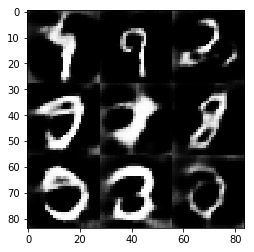

Epoch 2/2... Discriminator Loss: 0.8987... Generator Loss: 0.9910
Epoch 2/2... Discriminator Loss: 1.2408... Generator Loss: 0.4805
Epoch 2/2... Discriminator Loss: 1.0696... Generator Loss: 1.1688
Epoch 2/2... Discriminator Loss: 0.8408... Generator Loss: 1.5538
generator.z.shape: (?, 100)
gen.x1.shape: (?, 4, 4, 512)
gen.x2.shape: (?, 8, 8, 256)
gen.x3.shape: (?, 16, 16, 128)
gen.logits.shape: (?, 28, 28, 1)


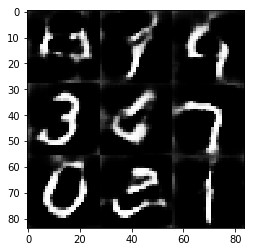

Epoch 2/2... Discriminator Loss: 0.9605... Generator Loss: 0.7891
Epoch 2/2... Discriminator Loss: 1.0552... Generator Loss: 1.1932
Epoch 2/2... Discriminator Loss: 0.9252... Generator Loss: 1.0271
Epoch 2/2... Discriminator Loss: 0.8682... Generator Loss: 0.8822
generator.z.shape: (?, 100)
gen.x1.shape: (?, 4, 4, 512)
gen.x2.shape: (?, 8, 8, 256)
gen.x3.shape: (?, 16, 16, 128)
gen.logits.shape: (?, 28, 28, 1)


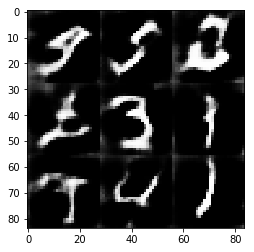

Epoch 2/2... Discriminator Loss: 1.2410... Generator Loss: 0.5514


In [15]:
!mkdir checkpoints

batch_size = 128
z_dim = 100
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
tf.reset_default_graph()

with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

data shape: (202599, 28, 28, 3)
height: 28, width: 28, channels: 3, z_dim: 200
Epoch 1/5... Discriminator Loss: 0.9591... Generator Loss: 1.0411
Epoch 1/5... Discriminator Loss: 0.6617... Generator Loss: 1.2399
Epoch 1/5... Discriminator Loss: 1.2100... Generator Loss: 1.1002
Epoch 1/5... Discriminator Loss: 1.1082... Generator Loss: 0.9481


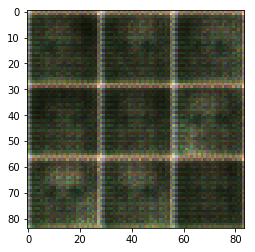

Epoch 1/5... Discriminator Loss: 1.2483... Generator Loss: 0.7879
Epoch 1/5... Discriminator Loss: 1.5655... Generator Loss: 0.5980
Epoch 1/5... Discriminator Loss: 1.3120... Generator Loss: 1.2057
Epoch 1/5... Discriminator Loss: 1.0840... Generator Loss: 0.7725


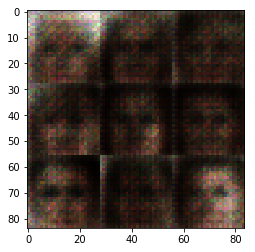

Epoch 1/5... Discriminator Loss: 1.1001... Generator Loss: 0.8537
Epoch 1/5... Discriminator Loss: 2.0045... Generator Loss: 0.3693
Epoch 1/5... Discriminator Loss: 1.2123... Generator Loss: 0.8294
Epoch 1/5... Discriminator Loss: 0.9289... Generator Loss: 1.0034


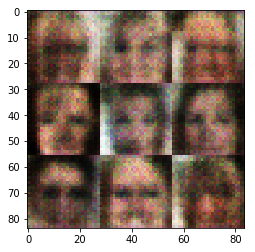

Epoch 1/5... Discriminator Loss: 1.0337... Generator Loss: 1.2392
Epoch 1/5... Discriminator Loss: 1.3837... Generator Loss: 1.4580
Epoch 1/5... Discriminator Loss: 1.2834... Generator Loss: 0.7285
Epoch 1/5... Discriminator Loss: 1.1029... Generator Loss: 0.7397


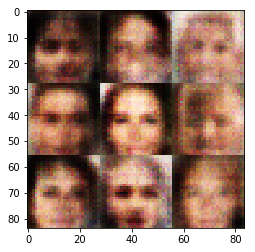

Epoch 1/5... Discriminator Loss: 0.8677... Generator Loss: 1.0509
Epoch 1/5... Discriminator Loss: 1.4707... Generator Loss: 0.6679
Epoch 1/5... Discriminator Loss: 1.4000... Generator Loss: 0.7535
Epoch 1/5... Discriminator Loss: 1.4460... Generator Loss: 0.5096


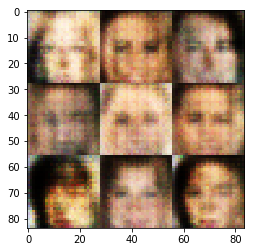

Epoch 1/5... Discriminator Loss: 1.4002... Generator Loss: 0.8131
Epoch 1/5... Discriminator Loss: 1.2501... Generator Loss: 0.6465
Epoch 1/5... Discriminator Loss: 1.2809... Generator Loss: 0.7532
Epoch 1/5... Discriminator Loss: 1.2782... Generator Loss: 0.6871


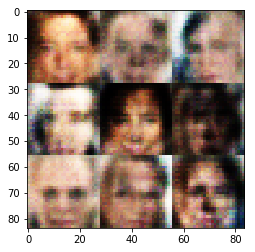

Epoch 1/5... Discriminator Loss: 1.3169... Generator Loss: 0.7443
Epoch 1/5... Discriminator Loss: 1.2708... Generator Loss: 0.6845
Epoch 1/5... Discriminator Loss: 1.1802... Generator Loss: 0.9467
Epoch 1/5... Discriminator Loss: 1.3095... Generator Loss: 0.8616


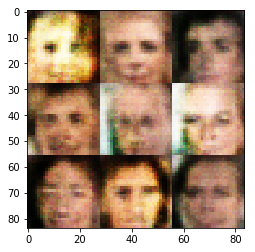

Epoch 1/5... Discriminator Loss: 1.2440... Generator Loss: 0.7451
Epoch 1/5... Discriminator Loss: 1.2411... Generator Loss: 1.1677
Epoch 1/5... Discriminator Loss: 1.3195... Generator Loss: 0.7800
Epoch 1/5... Discriminator Loss: 1.2615... Generator Loss: 0.6627


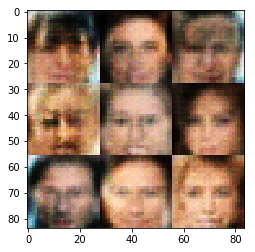

Epoch 1/5... Discriminator Loss: 1.1477... Generator Loss: 0.8074
Epoch 1/5... Discriminator Loss: 1.2851... Generator Loss: 0.7989
Epoch 1/5... Discriminator Loss: 1.1634... Generator Loss: 0.9012
Epoch 1/5... Discriminator Loss: 1.1206... Generator Loss: 0.7534


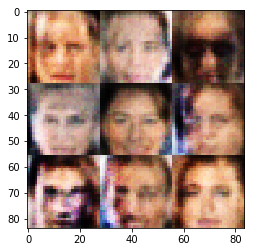

Epoch 1/5... Discriminator Loss: 1.1753... Generator Loss: 0.8247
Epoch 1/5... Discriminator Loss: 1.0867... Generator Loss: 0.7451
Epoch 1/5... Discriminator Loss: 1.1399... Generator Loss: 0.7520
Epoch 1/5... Discriminator Loss: 1.1966... Generator Loss: 0.7910


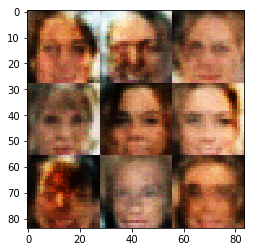

Epoch 1/5... Discriminator Loss: 1.1720... Generator Loss: 0.9091
Epoch 1/5... Discriminator Loss: 1.0116... Generator Loss: 0.8771
Epoch 1/5... Discriminator Loss: 1.2347... Generator Loss: 0.6648
Epoch 1/5... Discriminator Loss: 1.2093... Generator Loss: 0.6848


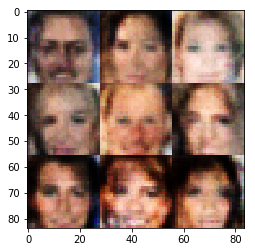

Epoch 1/5... Discriminator Loss: 1.1808... Generator Loss: 0.6150
Epoch 1/5... Discriminator Loss: 1.1636... Generator Loss: 0.8817
Epoch 1/5... Discriminator Loss: 1.2328... Generator Loss: 0.4971
Epoch 1/5... Discriminator Loss: 1.1061... Generator Loss: 1.1577


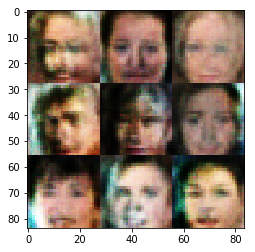

Epoch 1/5... Discriminator Loss: 1.2188... Generator Loss: 0.7319
Epoch 1/5... Discriminator Loss: 1.1286... Generator Loss: 0.7025
Epoch 1/5... Discriminator Loss: 1.2078... Generator Loss: 1.1384
Epoch 1/5... Discriminator Loss: 0.7985... Generator Loss: 1.5976


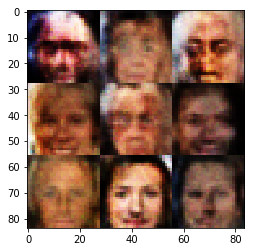

Epoch 1/5... Discriminator Loss: 1.3292... Generator Loss: 0.5103
Epoch 1/5... Discriminator Loss: 0.8914... Generator Loss: 1.2225
Epoch 1/5... Discriminator Loss: 1.0837... Generator Loss: 1.0855
Epoch 1/5... Discriminator Loss: 1.0009... Generator Loss: 0.8671


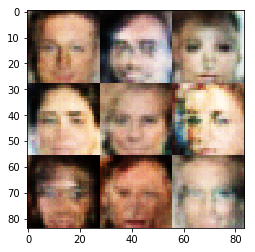

Epoch 1/5... Discriminator Loss: 1.0719... Generator Loss: 0.6676
Epoch 1/5... Discriminator Loss: 1.0222... Generator Loss: 0.9024
Epoch 1/5... Discriminator Loss: 0.6901... Generator Loss: 1.3201
Epoch 1/5... Discriminator Loss: 0.7974... Generator Loss: 2.3748


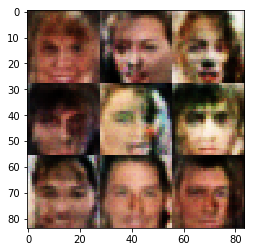

Epoch 1/5... Discriminator Loss: 0.9095... Generator Loss: 1.4163
Epoch 1/5... Discriminator Loss: 0.6989... Generator Loss: 2.3265
Epoch 1/5... Discriminator Loss: 1.3956... Generator Loss: 0.3645
Epoch 2/5... Discriminator Loss: 0.5734... Generator Loss: 3.5058


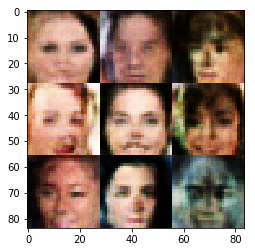

Epoch 2/5... Discriminator Loss: 0.8088... Generator Loss: 1.7391
Epoch 2/5... Discriminator Loss: 0.7372... Generator Loss: 0.9186
Epoch 2/5... Discriminator Loss: 1.0792... Generator Loss: 0.5737
Epoch 2/5... Discriminator Loss: 0.6288... Generator Loss: 1.5971


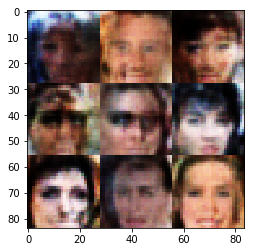

Epoch 2/5... Discriminator Loss: 1.2257... Generator Loss: 0.4316
Epoch 2/5... Discriminator Loss: 1.1637... Generator Loss: 0.4976
Epoch 2/5... Discriminator Loss: 0.3898... Generator Loss: 1.8291
Epoch 2/5... Discriminator Loss: 0.3342... Generator Loss: 3.6816


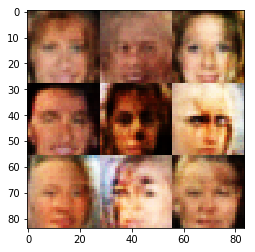

Epoch 2/5... Discriminator Loss: 1.6889... Generator Loss: 0.2675
Epoch 2/5... Discriminator Loss: 0.3752... Generator Loss: 4.4860
Epoch 2/5... Discriminator Loss: 0.8203... Generator Loss: 7.0697
Epoch 2/5... Discriminator Loss: 0.2824... Generator Loss: 3.0383


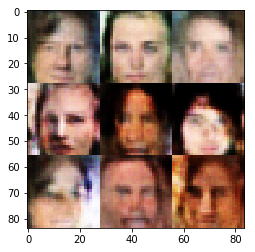

Epoch 2/5... Discriminator Loss: 0.3766... Generator Loss: 3.1860
Epoch 2/5... Discriminator Loss: 0.6677... Generator Loss: 3.7221
Epoch 2/5... Discriminator Loss: 0.7073... Generator Loss: 0.9047
Epoch 2/5... Discriminator Loss: 0.4739... Generator Loss: 3.3330


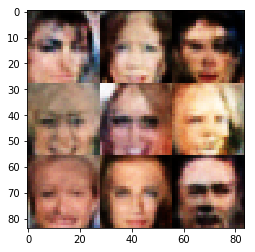

Epoch 2/5... Discriminator Loss: 0.8955... Generator Loss: 0.7236
Epoch 2/5... Discriminator Loss: 0.1936... Generator Loss: 5.1969
Epoch 2/5... Discriminator Loss: 0.2562... Generator Loss: 1.9165
Epoch 2/5... Discriminator Loss: 0.3967... Generator Loss: 2.0415


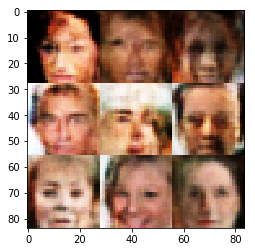

Epoch 2/5... Discriminator Loss: 0.4577... Generator Loss: 1.4768
Epoch 2/5... Discriminator Loss: 0.1174... Generator Loss: 3.3316
Epoch 2/5... Discriminator Loss: 0.4500... Generator Loss: 1.8931
Epoch 2/5... Discriminator Loss: 0.2691... Generator Loss: 4.2016


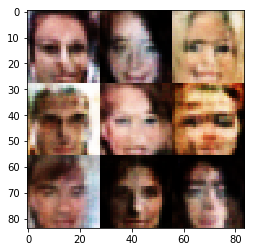

Epoch 2/5... Discriminator Loss: 0.3001... Generator Loss: 5.4830
Epoch 2/5... Discriminator Loss: 1.1251... Generator Loss: 4.7212
Epoch 2/5... Discriminator Loss: 0.1593... Generator Loss: 4.6104
Epoch 2/5... Discriminator Loss: 0.9843... Generator Loss: 0.6022


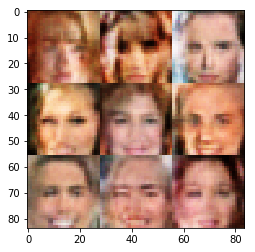

Epoch 2/5... Discriminator Loss: 0.4193... Generator Loss: 7.6543
Epoch 2/5... Discriminator Loss: 1.0303... Generator Loss: 0.6642
Epoch 2/5... Discriminator Loss: 0.4481... Generator Loss: 6.9754
Epoch 2/5... Discriminator Loss: 0.6204... Generator Loss: 7.3111


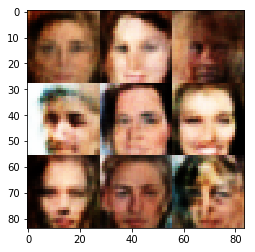

Epoch 2/5... Discriminator Loss: 0.1578... Generator Loss: 3.2964
Epoch 2/5... Discriminator Loss: 0.3093... Generator Loss: 5.7771
Epoch 2/5... Discriminator Loss: 0.2471... Generator Loss: 2.2412
Epoch 2/5... Discriminator Loss: 0.1533... Generator Loss: 6.6064


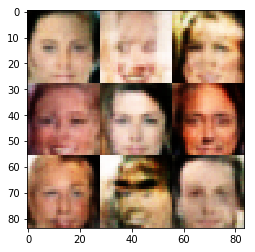

Epoch 2/5... Discriminator Loss: 1.3728... Generator Loss: 0.4113
Epoch 2/5... Discriminator Loss: 0.1854... Generator Loss: 4.7720
Epoch 2/5... Discriminator Loss: 0.1810... Generator Loss: 3.7120
Epoch 2/5... Discriminator Loss: 0.0774... Generator Loss: 8.4381


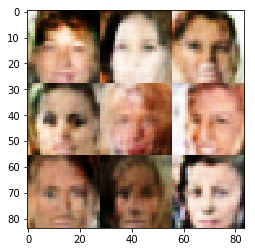

Epoch 2/5... Discriminator Loss: 0.3700... Generator Loss: 1.5612
Epoch 2/5... Discriminator Loss: 0.2589... Generator Loss: 6.4301
Epoch 2/5... Discriminator Loss: 0.1438... Generator Loss: 4.6833
Epoch 2/5... Discriminator Loss: 0.3056... Generator Loss: 6.0192


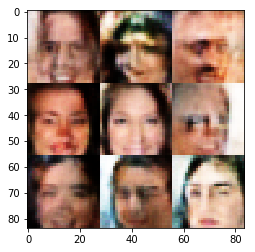

Epoch 2/5... Discriminator Loss: 0.1443... Generator Loss: 2.9830
Epoch 2/5... Discriminator Loss: 1.8442... Generator Loss: 0.2057
Epoch 2/5... Discriminator Loss: 0.4452... Generator Loss: 1.4154
Epoch 2/5... Discriminator Loss: 0.7468... Generator Loss: 0.8432


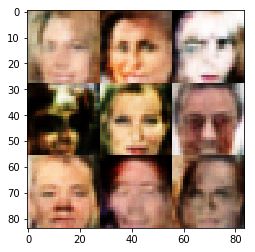

Epoch 2/5... Discriminator Loss: 0.3356... Generator Loss: 1.8429
Epoch 2/5... Discriminator Loss: 0.2241... Generator Loss: 3.0100
Epoch 2/5... Discriminator Loss: 0.0709... Generator Loss: 5.5120
Epoch 2/5... Discriminator Loss: 0.2411... Generator Loss: 4.8082


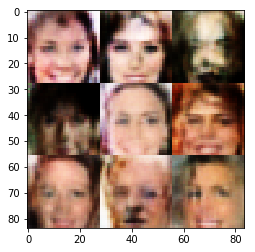

Epoch 2/5... Discriminator Loss: 0.3250... Generator Loss: 1.8826
Epoch 2/5... Discriminator Loss: 0.3578... Generator Loss: 1.5996
Epoch 2/5... Discriminator Loss: 0.1931... Generator Loss: 8.8503
Epoch 2/5... Discriminator Loss: 0.1822... Generator Loss: 2.7827


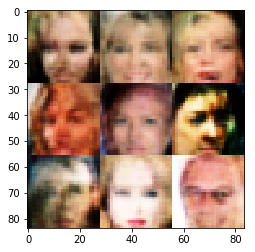

Epoch 2/5... Discriminator Loss: 0.1760... Generator Loss: 5.4649
Epoch 2/5... Discriminator Loss: 0.5551... Generator Loss: 1.2730
Epoch 2/5... Discriminator Loss: 0.1984... Generator Loss: 7.2022
Epoch 2/5... Discriminator Loss: 0.2758... Generator Loss: 1.7897


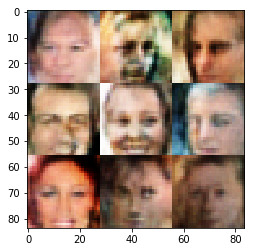

Epoch 2/5... Discriminator Loss: 1.0185... Generator Loss: 0.6008
Epoch 2/5... Discriminator Loss: 0.3610... Generator Loss: 1.9976
Epoch 3/5... Discriminator Loss: 1.1480... Generator Loss: 0.4813
Epoch 3/5... Discriminator Loss: 0.2527... Generator Loss: 2.1417


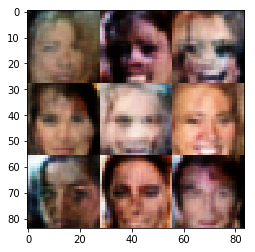

Epoch 3/5... Discriminator Loss: 0.1937... Generator Loss: 4.6734
Epoch 3/5... Discriminator Loss: 0.0841... Generator Loss: 5.1241
Epoch 3/5... Discriminator Loss: 0.3497... Generator Loss: 4.3279
Epoch 3/5... Discriminator Loss: 0.0694... Generator Loss: 6.2422


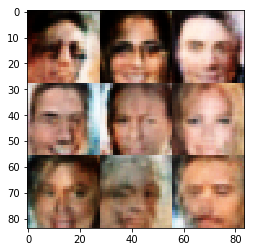

Epoch 3/5... Discriminator Loss: 0.1730... Generator Loss: 3.7585
Epoch 3/5... Discriminator Loss: 1.3845... Generator Loss: 0.3716
Epoch 3/5... Discriminator Loss: 0.5444... Generator Loss: 1.1387
Epoch 3/5... Discriminator Loss: 0.2924... Generator Loss: 1.9749


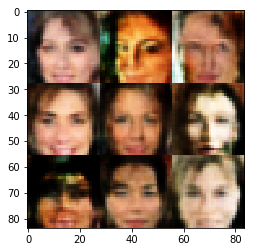

Epoch 3/5... Discriminator Loss: 0.2236... Generator Loss: 2.3356
Epoch 3/5... Discriminator Loss: 0.0592... Generator Loss: 5.8467
Epoch 3/5... Discriminator Loss: 0.1647... Generator Loss: 2.8723
Epoch 3/5... Discriminator Loss: 0.5501... Generator Loss: 1.1655


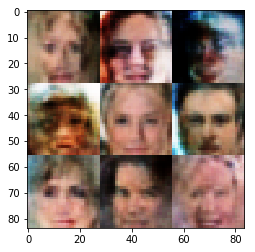

Epoch 3/5... Discriminator Loss: 0.0619... Generator Loss: 4.7024
Epoch 3/5... Discriminator Loss: 3.1460... Generator Loss: 0.0804
Epoch 3/5... Discriminator Loss: 0.2873... Generator Loss: 2.2329
Epoch 3/5... Discriminator Loss: 0.2638... Generator Loss: 3.6373


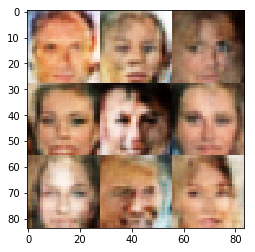

Epoch 3/5... Discriminator Loss: 0.4873... Generator Loss: 1.3061
Epoch 3/5... Discriminator Loss: 0.3791... Generator Loss: 1.5827
Epoch 3/5... Discriminator Loss: 0.1569... Generator Loss: 2.5597
Epoch 3/5... Discriminator Loss: 0.2309... Generator Loss: 3.1010


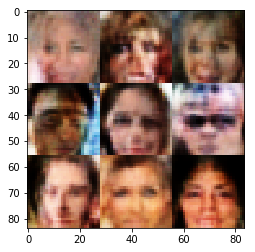

Epoch 3/5... Discriminator Loss: 0.3541... Generator Loss: 1.5596
Epoch 3/5... Discriminator Loss: 0.0702... Generator Loss: 5.0677
Epoch 3/5... Discriminator Loss: 0.0469... Generator Loss: 4.8139
Epoch 3/5... Discriminator Loss: 0.1141... Generator Loss: 3.9701


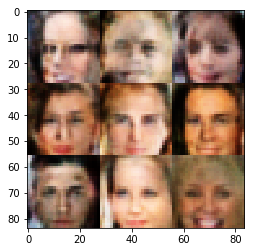

Epoch 3/5... Discriminator Loss: 0.4459... Generator Loss: 1.4307
Epoch 3/5... Discriminator Loss: 0.3781... Generator Loss: 1.5688
Epoch 3/5... Discriminator Loss: 0.3928... Generator Loss: 1.5175
Epoch 3/5... Discriminator Loss: 0.4109... Generator Loss: 3.0540


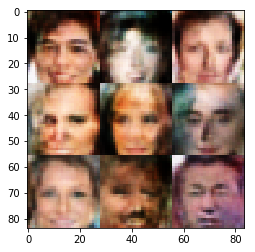

Epoch 3/5... Discriminator Loss: 0.0916... Generator Loss: 6.8957
Epoch 3/5... Discriminator Loss: 0.0823... Generator Loss: 5.2775
Epoch 3/5... Discriminator Loss: 1.0810... Generator Loss: 1.2184
Epoch 3/5... Discriminator Loss: 0.2977... Generator Loss: 2.8992


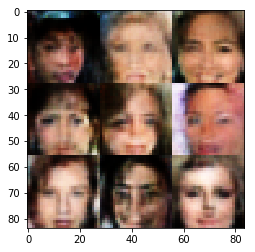

Epoch 3/5... Discriminator Loss: 0.0810... Generator Loss: 4.3317
Epoch 3/5... Discriminator Loss: 0.2050... Generator Loss: 2.5385
Epoch 3/5... Discriminator Loss: 0.0834... Generator Loss: 4.6395
Epoch 3/5... Discriminator Loss: 0.2035... Generator Loss: 2.4153


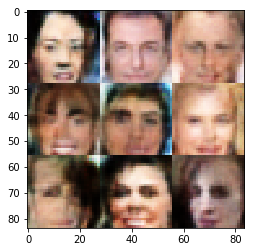

Epoch 3/5... Discriminator Loss: 0.2352... Generator Loss: 2.1517
Epoch 3/5... Discriminator Loss: 0.0654... Generator Loss: 4.4435
Epoch 3/5... Discriminator Loss: 0.1195... Generator Loss: 4.0377
Epoch 3/5... Discriminator Loss: 0.0879... Generator Loss: 3.8568


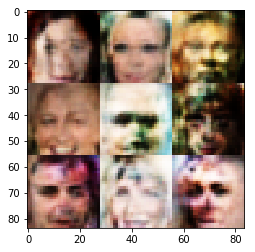

Epoch 3/5... Discriminator Loss: 0.1182... Generator Loss: 3.9282
Epoch 3/5... Discriminator Loss: 0.3435... Generator Loss: 1.9879
Epoch 3/5... Discriminator Loss: 0.6452... Generator Loss: 2.8999
Epoch 3/5... Discriminator Loss: 0.1903... Generator Loss: 2.8802


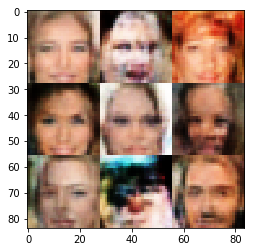

Epoch 3/5... Discriminator Loss: 0.1886... Generator Loss: 2.8380
Epoch 3/5... Discriminator Loss: 0.5496... Generator Loss: 1.1386
Epoch 3/5... Discriminator Loss: 0.1205... Generator Loss: 4.4452
Epoch 3/5... Discriminator Loss: 0.1586... Generator Loss: 3.6744


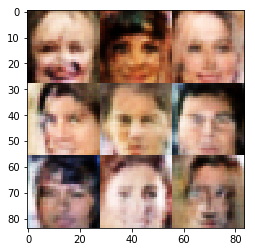

Epoch 3/5... Discriminator Loss: 0.2805... Generator Loss: 1.8986
Epoch 3/5... Discriminator Loss: 2.0196... Generator Loss: 0.2244
Epoch 3/5... Discriminator Loss: 0.1635... Generator Loss: 3.8219
Epoch 3/5... Discriminator Loss: 0.1760... Generator Loss: 2.5715


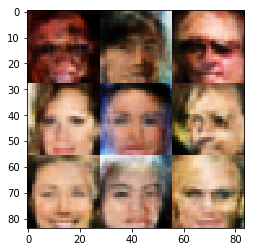

Epoch 3/5... Discriminator Loss: 0.0409... Generator Loss: 6.4593
Epoch 3/5... Discriminator Loss: 0.0572... Generator Loss: 5.9973
Epoch 3/5... Discriminator Loss: 1.4185... Generator Loss: 0.3969
Epoch 3/5... Discriminator Loss: 0.3494... Generator Loss: 3.5065


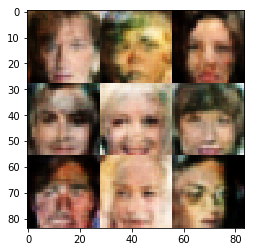

Epoch 3/5... Discriminator Loss: 0.6558... Generator Loss: 0.9896
Epoch 3/5... Discriminator Loss: 0.2692... Generator Loss: 2.6305
Epoch 3/5... Discriminator Loss: 0.1365... Generator Loss: 3.6427
Epoch 3/5... Discriminator Loss: 0.0917... Generator Loss: 5.6077


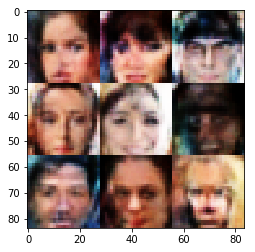

Epoch 3/5... Discriminator Loss: 0.1375... Generator Loss: 2.7625
Epoch 4/5... Discriminator Loss: 0.1426... Generator Loss: 4.2561
Epoch 4/5... Discriminator Loss: 0.3676... Generator Loss: 1.9712
Epoch 4/5... Discriminator Loss: 0.2651... Generator Loss: 3.1921


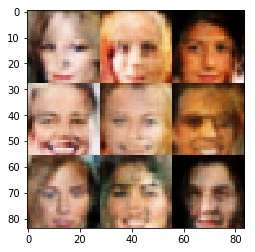

Epoch 4/5... Discriminator Loss: 1.0398... Generator Loss: 0.5459
Epoch 4/5... Discriminator Loss: 0.1272... Generator Loss: 4.8059
Epoch 4/5... Discriminator Loss: 0.0643... Generator Loss: 4.3812
Epoch 4/5... Discriminator Loss: 0.2082... Generator Loss: 2.3046


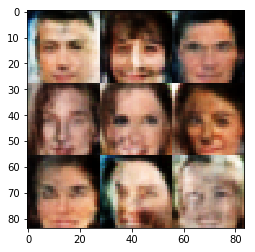

Epoch 4/5... Discriminator Loss: 0.2920... Generator Loss: 4.3027
Epoch 4/5... Discriminator Loss: 0.3338... Generator Loss: 2.7929
Epoch 4/5... Discriminator Loss: 0.2140... Generator Loss: 2.5858
Epoch 4/5... Discriminator Loss: 0.2137... Generator Loss: 2.4801


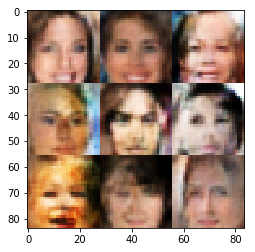

Epoch 4/5... Discriminator Loss: 1.1907... Generator Loss: 0.4851
Epoch 4/5... Discriminator Loss: 0.4598... Generator Loss: 1.2717
Epoch 4/5... Discriminator Loss: 1.9816... Generator Loss: 3.3726
Epoch 4/5... Discriminator Loss: 0.4201... Generator Loss: 2.7623


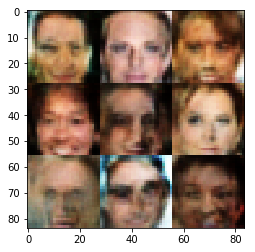

Epoch 4/5... Discriminator Loss: 0.4133... Generator Loss: 3.4466
Epoch 4/5... Discriminator Loss: 0.2760... Generator Loss: 2.3268
Epoch 4/5... Discriminator Loss: 0.1577... Generator Loss: 3.1160
Epoch 4/5... Discriminator Loss: 0.1005... Generator Loss: 7.6007


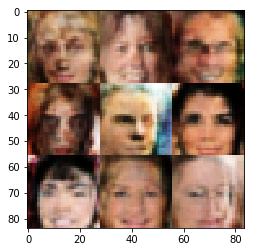

Epoch 4/5... Discriminator Loss: 0.3190... Generator Loss: 2.0656
Epoch 4/5... Discriminator Loss: 0.2142... Generator Loss: 4.1034
Epoch 4/5... Discriminator Loss: 0.1401... Generator Loss: 5.6822
Epoch 4/5... Discriminator Loss: 0.1634... Generator Loss: 2.9740


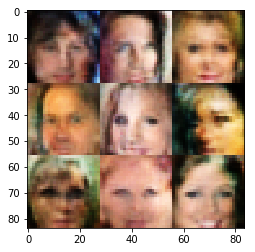

Epoch 4/5... Discriminator Loss: 0.2227... Generator Loss: 3.2263
Epoch 4/5... Discriminator Loss: 0.3569... Generator Loss: 1.5778
Epoch 4/5... Discriminator Loss: 0.4523... Generator Loss: 1.2743
Epoch 4/5... Discriminator Loss: 0.2962... Generator Loss: 1.7927


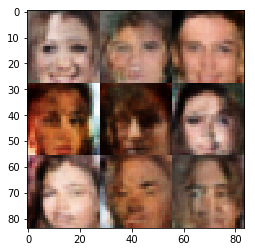

Epoch 4/5... Discriminator Loss: 0.2371... Generator Loss: 4.2942
Epoch 4/5... Discriminator Loss: 0.2279... Generator Loss: 2.6580
Epoch 4/5... Discriminator Loss: 0.4861... Generator Loss: 5.9197
Epoch 4/5... Discriminator Loss: 0.0915... Generator Loss: 4.5686


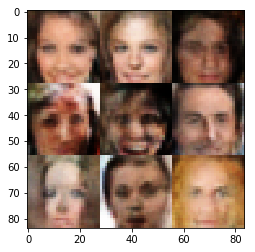

Epoch 4/5... Discriminator Loss: 0.3286... Generator Loss: 2.8453
Epoch 4/5... Discriminator Loss: 0.3470... Generator Loss: 1.8759
Epoch 4/5... Discriminator Loss: 0.0721... Generator Loss: 5.0997
Epoch 4/5... Discriminator Loss: 0.2943... Generator Loss: 1.7451


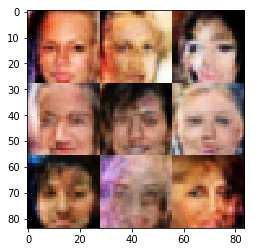

Epoch 4/5... Discriminator Loss: 0.1452... Generator Loss: 3.0051
Epoch 4/5... Discriminator Loss: 0.4415... Generator Loss: 1.3842
Epoch 4/5... Discriminator Loss: 0.5106... Generator Loss: 5.2840
Epoch 4/5... Discriminator Loss: 0.1823... Generator Loss: 2.6507


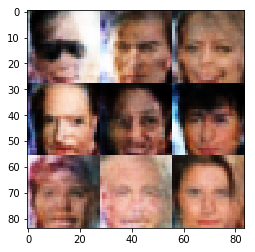

Epoch 4/5... Discriminator Loss: 0.3532... Generator Loss: 1.7142
Epoch 4/5... Discriminator Loss: 0.0923... Generator Loss: 4.6148
Epoch 4/5... Discriminator Loss: 0.0265... Generator Loss: 6.7665
Epoch 4/5... Discriminator Loss: 0.0720... Generator Loss: 4.7238


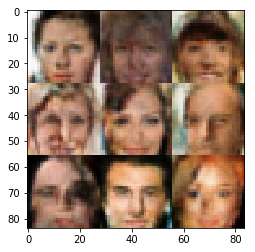

Epoch 4/5... Discriminator Loss: 0.2359... Generator Loss: 2.2641
Epoch 4/5... Discriminator Loss: 0.1215... Generator Loss: 2.8999
Epoch 4/5... Discriminator Loss: 0.1261... Generator Loss: 8.7217
Epoch 4/5... Discriminator Loss: 0.1236... Generator Loss: 4.9120


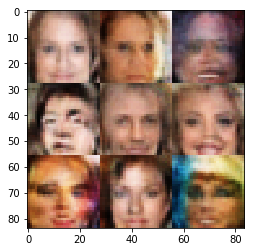

Epoch 4/5... Discriminator Loss: 0.1837... Generator Loss: 2.5701
Epoch 4/5... Discriminator Loss: 1.1687... Generator Loss: 5.7315
Epoch 4/5... Discriminator Loss: 0.7398... Generator Loss: 1.2045
Epoch 4/5... Discriminator Loss: 0.2442... Generator Loss: 1.9078


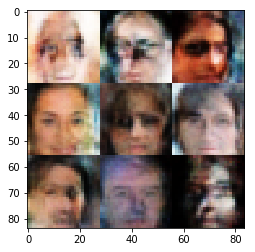

Epoch 4/5... Discriminator Loss: 1.0725... Generator Loss: 0.5882
Epoch 4/5... Discriminator Loss: 0.2440... Generator Loss: 2.1971
Epoch 4/5... Discriminator Loss: 0.6424... Generator Loss: 1.0380
Epoch 4/5... Discriminator Loss: 0.2543... Generator Loss: 5.0111


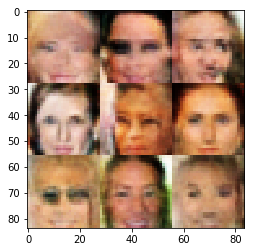

Epoch 4/5... Discriminator Loss: 0.3521... Generator Loss: 1.9482
Epoch 4/5... Discriminator Loss: 0.2884... Generator Loss: 8.4993
Epoch 4/5... Discriminator Loss: 0.5307... Generator Loss: 1.2646
Epoch 4/5... Discriminator Loss: 0.3571... Generator Loss: 1.5870


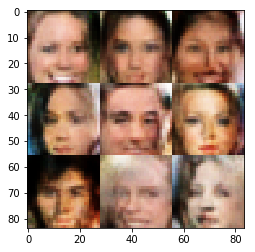

Epoch 4/5... Discriminator Loss: 0.1218... Generator Loss: 3.3897
Epoch 4/5... Discriminator Loss: 0.2535... Generator Loss: 3.3175
Epoch 4/5... Discriminator Loss: 0.6625... Generator Loss: 1.8659
Epoch 4/5... Discriminator Loss: 1.2089... Generator Loss: 0.4718


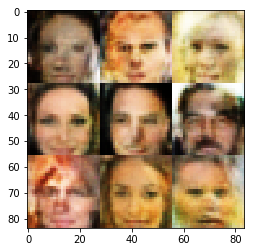

Epoch 4/5... Discriminator Loss: 0.4790... Generator Loss: 1.3099
Epoch 5/5... Discriminator Loss: 0.7631... Generator Loss: 0.8202
Epoch 5/5... Discriminator Loss: 0.8269... Generator Loss: 0.7806
Epoch 5/5... Discriminator Loss: 0.4615... Generator Loss: 1.2947


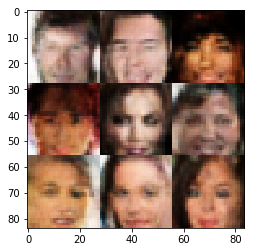

Epoch 5/5... Discriminator Loss: 0.2047... Generator Loss: 2.5305
Epoch 5/5... Discriminator Loss: 0.2562... Generator Loss: 1.9646
Epoch 5/5... Discriminator Loss: 0.2186... Generator Loss: 2.3880
Epoch 5/5... Discriminator Loss: 0.5741... Generator Loss: 1.0711


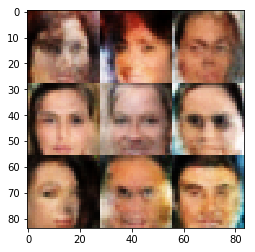

Epoch 5/5... Discriminator Loss: 0.8437... Generator Loss: 0.6912
Epoch 5/5... Discriminator Loss: 0.2863... Generator Loss: 2.0355
Epoch 5/5... Discriminator Loss: 0.2752... Generator Loss: 1.9833
Epoch 5/5... Discriminator Loss: 0.2272... Generator Loss: 2.1763


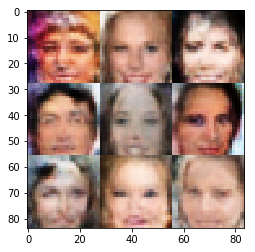

Epoch 5/5... Discriminator Loss: 0.2877... Generator Loss: 3.6094
Epoch 5/5... Discriminator Loss: 0.1196... Generator Loss: 4.5518
Epoch 5/5... Discriminator Loss: 0.1657... Generator Loss: 3.2894
Epoch 5/5... Discriminator Loss: 0.2410... Generator Loss: 2.1088


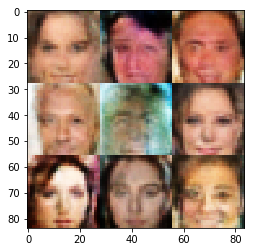

Epoch 5/5... Discriminator Loss: 0.1897... Generator Loss: 2.2908
Epoch 5/5... Discriminator Loss: 1.6618... Generator Loss: 0.3108
Epoch 5/5... Discriminator Loss: 0.2989... Generator Loss: 1.8174
Epoch 5/5... Discriminator Loss: 1.5397... Generator Loss: 2.5298


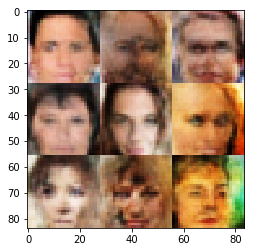

Epoch 5/5... Discriminator Loss: 0.2158... Generator Loss: 4.5798
Epoch 5/5... Discriminator Loss: 0.4569... Generator Loss: 1.3725
Epoch 5/5... Discriminator Loss: 0.3573... Generator Loss: 1.9729
Epoch 5/5... Discriminator Loss: 0.6667... Generator Loss: 0.9035


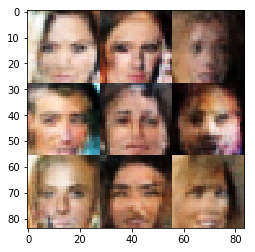

Epoch 5/5... Discriminator Loss: 0.1708... Generator Loss: 2.8318
Epoch 5/5... Discriminator Loss: 0.0910... Generator Loss: 7.2004
Epoch 5/5... Discriminator Loss: 1.7899... Generator Loss: 0.2692
Epoch 5/5... Discriminator Loss: 0.5384... Generator Loss: 1.2076


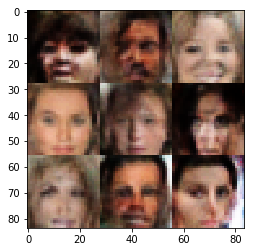

Epoch 5/5... Discriminator Loss: 0.4456... Generator Loss: 1.2687
Epoch 5/5... Discriminator Loss: 0.1750... Generator Loss: 4.2197
Epoch 5/5... Discriminator Loss: 0.4427... Generator Loss: 1.3964
Epoch 5/5... Discriminator Loss: 0.3159... Generator Loss: 1.6780


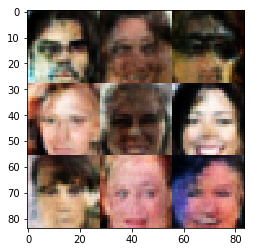

Epoch 5/5... Discriminator Loss: 0.0942... Generator Loss: 3.5812
Epoch 5/5... Discriminator Loss: 0.1013... Generator Loss: 4.2681
Epoch 5/5... Discriminator Loss: 0.2646... Generator Loss: 2.1873
Epoch 5/5... Discriminator Loss: 0.4477... Generator Loss: 1.3981


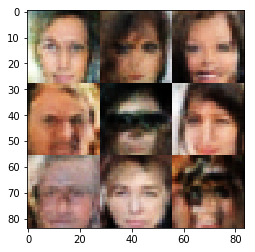

Epoch 5/5... Discriminator Loss: 0.4288... Generator Loss: 1.7429
Epoch 5/5... Discriminator Loss: 0.3582... Generator Loss: 1.6268
Epoch 5/5... Discriminator Loss: 0.3471... Generator Loss: 1.6959
Epoch 5/5... Discriminator Loss: 0.2275... Generator Loss: 2.6986


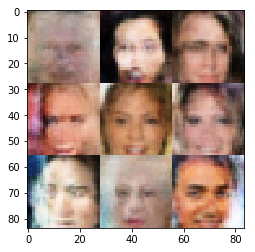

Epoch 5/5... Discriminator Loss: 0.1895... Generator Loss: 2.6378
Epoch 5/5... Discriminator Loss: 0.4193... Generator Loss: 1.4086
Epoch 5/5... Discriminator Loss: 0.7930... Generator Loss: 0.7657
Epoch 5/5... Discriminator Loss: 0.1893... Generator Loss: 2.3249


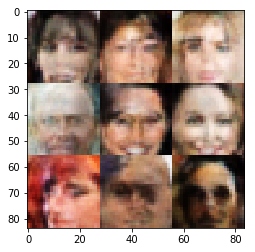

Epoch 5/5... Discriminator Loss: 1.0691... Generator Loss: 0.5302
Epoch 5/5... Discriminator Loss: 0.2546... Generator Loss: 2.0413
Epoch 5/5... Discriminator Loss: 0.4096... Generator Loss: 5.8819
Epoch 5/5... Discriminator Loss: 0.3177... Generator Loss: 1.6289


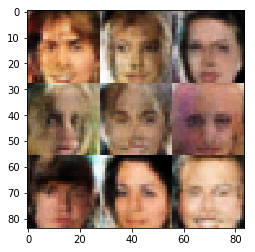

Epoch 5/5... Discriminator Loss: 0.3302... Generator Loss: 1.7017
Epoch 5/5... Discriminator Loss: 0.3449... Generator Loss: 2.0069
Epoch 5/5... Discriminator Loss: 1.2880... Generator Loss: 0.6263
Epoch 5/5... Discriminator Loss: 0.4801... Generator Loss: 1.7468


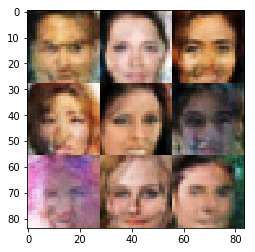

Epoch 5/5... Discriminator Loss: 0.7815... Generator Loss: 0.8067
Epoch 5/5... Discriminator Loss: 0.4501... Generator Loss: 1.3808
Epoch 5/5... Discriminator Loss: 0.3470... Generator Loss: 2.0586
Epoch 5/5... Discriminator Loss: 0.3859... Generator Loss: 1.7252


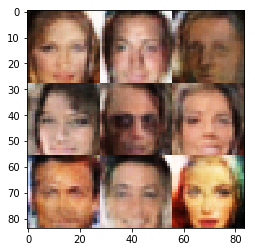

Epoch 5/5... Discriminator Loss: 0.5456... Generator Loss: 1.1038
Epoch 5/5... Discriminator Loss: 0.0502... Generator Loss: 6.4330
Epoch 5/5... Discriminator Loss: 0.2213... Generator Loss: 2.4388
Epoch 5/5... Discriminator Loss: 0.0632... Generator Loss: 7.3837


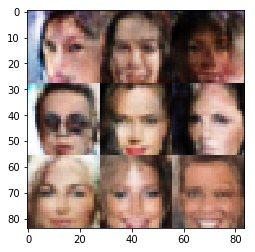

Epoch 5/5... Discriminator Loss: 0.8227... Generator Loss: 0.7300
Epoch 5/5... Discriminator Loss: 0.1775... Generator Loss: 2.9962
Epoch 5/5... Discriminator Loss: 0.4648... Generator Loss: 3.1411
Epoch 5/5... Discriminator Loss: 1.5251... Generator Loss: 0.3280


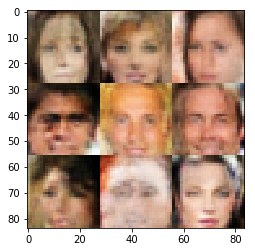

In [42]:
batch_size = 128
z_dim = 200
learning_rate = 0.0001
beta1 = 0.2


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 5

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
tf.reset_default_graph()

with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.